<a href="https://colab.research.google.com/github/ivan-mihailov/LS-Unit-4-Sprint-1/blob/main/Ivan_Mihailov_LS_DS_414_Topic_Modeling_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

**Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's using topic modeling: 

- Load in the Amazon Review dataset
- Clean the dataset 
- Vectorize the dataset 
- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [2]:
!git clone https://github.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP.git

Cloning into 'DS-Unit-4-Sprint-1-NLP'...
remote: Enumerating objects: 1528, done.
remote: Total 1528 (delta 0), reused 0 (delta 0), pack-reused 1528
Receiving objects: 100% (1528/1528), 56.37 MiB | 22.12 MiB/s, done.
Resolving deltas: 100% (169/169), done.


In [ ]:
!pip install pyLDAvis

In [ ]:
!pip install pandarallel==1.4.8

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import spacy
spacy.util.fix_random_seed(0)

import pyLDAvis
import pyLDAvis.gensim_models 

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from pandarallel import pandarallel

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

----
### Load the Amazon Review corpus 
This dataset is located in the Sprint 1 Module 1 directory. 

If the provided relative path doesn't work for you, then you'll have to provide the file path so pandas can read in the file.

In [5]:
!unzip '/content/DS-Unit-4-Sprint-1-NLP/module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip'

Archive:  /content/DS-Unit-4-Sprint-1-NLP/module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip
replace Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv  
   creating: __MACOSX/
  inflating: __MACOSX/._Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv  


In [4]:
data_path = "/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
df = pd.read_csv(data_path)

In [ ]:
df.head(2)

----

### Clean data

- Create a function called `clean_data` that uses regex expressions to clean your data in preparation for the vectorizer. 

- Save the clean text data to a column in your dataframe named `clean_text`

- Feel free to re-use old code that you have written in previous modules  

In [5]:
df.shape

(28332, 24)

In [20]:
df['reviews.text'][8505]

'Have had zero issues with longevity or voltage. As good as the major brand batteries'

In [6]:
def clean_data(text):
  """
  Cleans data to remove unwanted characters and punctuation.
  """
  # remove newline and '\xa0' characters
  text = " ".join(text.split())
  # remove punctuation
  text = re.sub('[^a-zA-Z$ 0-9]', '', text)
  # remove any double whitespaces created by cleaning
  text = re.sub("[ ]{2,}", ' ', text)

  return text.lower()

In [7]:
# save to cleaned review articles to a feature named `clean_text`
df['clean_text'] = df['reviews.text'].apply(clean_data)

In [8]:
alphebetical_chars = ["ABCDEFGHIJKLMNOP"]
# check if any of these alphabetical chars exist in your clean chars
assert df.clean_text.isin(alphebetical_chars).sum() == 0, "Did you case normalize your text inside of your clean_data function?"

------

## Determine number of topics

We are going to run an experiment to determine how many topics exists within the `primaryCategories` of `Electronics`. This is the largest primary category containing nearly 14K documents, so we should have plenty of data. 

Just as we did in the guided project, we'll be running a gridseach over the number of topics and scoring each model using the Coherence metric to determine which number of topics we should use. 


In [9]:
# create a mask for docs that are in the Electronics primaryCategories - save result to `electronics_mask`
electronics_mask = df.primaryCategories.isin(["Electronics"])

# use msak to isolate all the documents in the Electronics primaryCategories - save result to `df_electronics`
df_electronics = df[electronics_mask]

In [10]:
df_electronics.head(3)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,clean_text
8343,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,AmazonBasics,YBB12400R2,2017-11-12T00:00:00.000Z,2019-03-25T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.ebay.com/itm/Amazonbasics-Nylon-Cd...,Great case to keep everything in its place! My...,Excellent product,qs341_5,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,great case to keep everything in its place my ...
8344,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,AmazonBasics,YBB12400R2,2014-06-14T05:00:00Z,2014-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,http://www.amazon.co.uk/gp/product-reviews/B00...,After discarding and getting rid of broken cd ...,It was a much needed storage,Diablita,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,after discarding and getting rid of broken cd ...
8345,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,AmazonBasics,YBB12400R2,2019-02-15T00:00:00.000Z,2019-03-25T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.ebay.com/itm/Amazonbasics-Nylon-Cd...,"A few dollars more, but I am boycotting amazon",it was worth it,coldbloodblazing,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,a few dollars more but i am boycotting amazon


------
### Tokenize your documents 

Remember that you'll need to use the [**corpora**](https://radimrehurek.com/gensim/corpora/dictionary.html) class from the Gensim library. So definitely check out the docs to learn more about this tool. There is an example on how to do this in the guided project.

But before we can use the [**corpora**](https://radimrehurek.com/gensim/corpora/dictionary.html) class, we must first tokenize our articles. 



In [11]:
# identify how many processors your machine has - save the result to `n_processors`

# subtract 1 from n_processors - save the result to `nb_workers`

# initialize just like we did in the guided project
# COLAB only has 2 processors, set nb_workers=2 and hope that it doesn't crash your notebook (otherwise don't use this tool)
pandarallel.initialize(progress_bar=True, nb_workers=2)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
!python -m spacy download en_core_web_lg

In [12]:
# load in the spaCy language model
nlp = spacy.load("en_core_web_lg")

In [13]:
def tokenizer(text):
  lemmas = []
  for token in nlp(text):
    if (token.is_stop == False) & (token.is_punct == False) & (token.is_space == False):
      lemmas.append(token.lemma_.lower())
  return lemmas

In [14]:
%%time
# create our tokens in the form of lemmas 
df_electronics['lemmas'] = df_electronics['clean_text'].parallel_apply(tokenizer)

   0.00%                                          |        0 /     6998 |      
   0.00%                                          |        0 /     6997 |      M   0.00%                                          |        0 /     6998 |      
   0.99%                                          |       69 /     6997 |      M   0.00%                                          |        0 /     6998 |      
   1.26%                                          |       88 /     6997 |      M   0.00%                                          |        0 /     6998 |      
   1.61%                                          |      113 /     6997 |      M   0.99%                                

### Use the corpora class to prep your data for LDA

You'll need to create the same `id2word` and `corpus` objects that we created in the guided projects. So be sure to reference the guided project notebook if you need to. 

In [17]:
df_electronics['lemmas'][8343]

['great', 'case', 'place', 'husband', 'love', 'hold', 'lot', 'cd']

In [19]:
# Create lemma dictionary using Dictionary - save result to `id2word`
id2word = corpora.Dictionary(df_electronics['lemmas'])

# Create Term Document Frequency list - save result to `corpus`
corpus = [id2word.doc2bow(text) for text in df_electronics['lemmas']]

## Gridsearch the number of topics 

Just as we did in the guided project, we're going to run a for loop over a range of possible number of topics and then plot the coherence values to determine which number of topics leads to the most sensible grouping of documents. 

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df_electronics['lemmas'], start=2, limit=22, step=2)

CPU times: user 4min 28s, sys: 40 s, total: 5min 8s
Wall time: 10min 44s


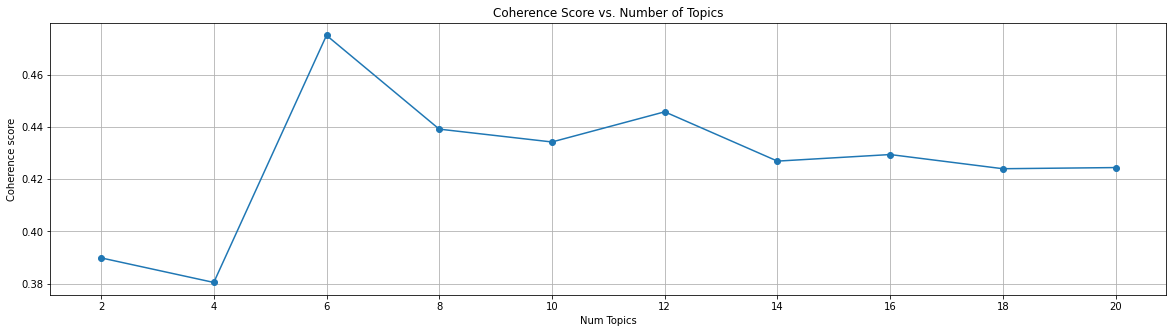

In [22]:
start=2; limit=22;  step=2;
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

In [23]:
# use np.argmax() to get index of largest coherence value from coherence_values - save result to `max_cohereance_val_index`

# use `max_cohereance_val_index` to index model_list for the corresponding model - save result to `lda_trained_model`

max_coherence_val_index = np.argmax(coherence_values)

lda_trained_model = model_list[max_coherence_val_index]

In [24]:
max_coherence_val_index

2

In [25]:
lda_trained_model

## Use pyLDAvis to visual your topics 

Take a look at the topic bubbles and bar char for the terms on the right hand side.  

- Describe the topic bubbles. 
- Do they overlap or not? 
- What does it mean when they overlap? 
- What does it mean when they don't overlap?
- Are the terms in each topic distinct from the topics in the other topic bubbles?


In [ ]:
!pip install ipywidgets

In [27]:
# plot your topics here
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_trained_model, 
                                     corpus=corpus, dictionary=id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.100118  0.100799       1        1  24.913430
3      0.110951  0.018098       2        1  19.345742
1      0.014577 -0.159058       3        1  18.612250
2      0.126986  0.026648       4        1  15.147796
4     -0.134697 -0.122785       5        1  14.232864
5     -0.217935  0.136298       6        1   7.747918, topic_info=       Term         Freq        Total Category  logprob  loglift
88     easy  2490.000000  2490.000000  Default  30.0000  30.0000
151     old  1851.000000  1851.000000  Default  29.0000  29.0000
6      love  4403.000000  4403.000000  Default  28.0000  28.0000
908    read  1630.000000  1630.000000  Default  27.0000  27.0000
1069   year  1503.000000  1503.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
51     want    81.118323   992.679279   Topic6  -5.2335   0.0532
6      love    90.693048  4403.262798   Topic6  -5.1220  -1.3249
94     good    86.856713  3102.940126   Topic6  -5.1652  -1.0181
409    have    71.769986   624.076049   Topic6  -5.3560   0.3949
42    small    68.761090   410.467903   Topic6  -5.3988   0.7711

[456 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1455      1  0.004984      $
1455      3  0.936931      $
1455      5  0.057312      $
2291      1  0.104138    100
2291      3  0.867820    100
...     ...       ...    ...
421       4  0.044526  worth
3923      4  0.897843   wrap
1069      1  0.999297   year
1563      1  0.994734     yr
3221      4  0.943335    yrs

[955 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3, 5, 6])

## Create a Topic id/name dictionary 

When populating your topic id/name dictionary, use the index ordering as shown in the viz tool. 

We'll use a function to map the the viz tool index ordering with the train LDA model ordering. 

In [28]:
# create a dictionary 
# keys - use topic ids from pyLDAvis visualization 
# values - topic names that you create 
# save dictionary to `vis_topic_name_dict`

vis_topic_name_dict = {1 : 'Kids Fire Tablet', 2 : 'Kindle',
                       3 : 'Fire Tablet', 4 : 'Kids Tablet',
                       5 : 'Tablet', 6 : 'Alexa Speaker'}

In [29]:
def get_topic_id_lookup_dict(vis, vis_topic_name_dict):
    """
    Both the starting index and the ordering of topic ids bewteen the trained LDA model 
    and the viz tool are different. So we need to create a look up dictionary that maps 
    the correct association between topic ids from both sources. 
    """
    # value is order of topic ids accoridng to pyLDAvis tool 
    # key is order of topic ids according to lda model
    model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()

    # invert dictionary so that 
    # key is order of topic ids accoridng to pyLDAvis tool 
    # value is order of topic ids according to lda model
    topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}
    
    return {v:vis_topic_name_dict[k]  for k, v in topic_id_lookup.items()}

In [33]:
topic_name_dict = get_topic_id_lookup_dict(vis, vis_topic_name_dict)

In [34]:
topic_name_dict

{0: 'Kids Fire Tablet',
 1: 'Fire Tablet',
 2: 'Kids Tablet',
 3: 'Kindle',
 4: 'Tablet',
 5: 'Alexa Speaker'}

## Assign Each Document a Topic Name

Now that we have a topic id/name look up dict that is aligned with the index ordering of the trained LDA model, we can move forward to giving each topic a topic name. 

The function below has been given to you. However, you highly encouraged to read through it and make sure that you understand what it is doing each step of the way. In fact, a good way to do this is to copy and paste the code inside of the function into a new cell, comment out all the lines of code and line by line, uncomment the code and see the output. 

In [30]:
def get_topic_ids_for_docs(lda_model, corpus):
    
    """
    Passes a Bag-of-Words vector into a trained LDA model in order to get the topic id of that document. 
    
    Parameters
    ----------
    lda_model: Gensim object
        Must be a trained model 
        
    corpus: nested lists of tuples, 
        i.e. [[(),(), ..., ()], [(),(), ..., ()], ..., [(),(), ..., ()]]
        
    Returns
    -------
    topic_id_list: list
        Contains topic ids for all document vectors in corpus 
    """
    
    # store topic ids for each document
    doc_topic_ids = []

    # iterature through the bow vectors for each doc
    for doc_bow in corpus:
        
        # store the topic ids for the doc
        topic_ids = []
        # store the topic probabilities for the doc
        topic_probs = []

        # list of tuples
        # each tuple has a topic id and the prob that the doc belongs to that topic 
        topic_id_prob_tuples = lda_trained_model.get_document_topics(doc_bow)
        
        # iterate through the topic id/prob pairs 
        for topic_id_prob in topic_id_prob_tuples:
            
            # index for topic id
            topic_id = topic_id_prob[0]
            # index for prob that doc belongs that the corresponding topic
            topic_prob = topic_id_prob[1]

            # store all topic ids for doc
            topic_ids.append(topic_id)
            # store all topic probs for doc
            topic_probs.append(topic_prob)

        # get index for largest prob score
        max_topic_prob_ind = np.argmax(topic_probs)
        # get corresponding topic id
        max_prob_topic_id = topic_ids[max_topic_prob_ind]
        # store topic id that had the highest prob for doc being a memebr of that topic
        doc_topic_ids.append(max_prob_topic_id)
        
    return doc_topic_ids

In [35]:
# use get_topic_ids_for_docs get the topic id for each doc in the corpus - save result to `doc_topic_ids`
doc_topic_ids = get_topic_ids_for_docs(lda_model=lda_trained_model, corpus=corpus)

# create a new feature in df_electronics called topic_id using `doc_topic_ids`
df_electronics['topic_id'] = doc_topic_ids

# iterate through topic_id and use the lookup dict `topic_name_dict` to assign each document a topic name
# save results to a new feature in df_electronics called `new_topic_name`
df_electronics['new_topic_name'] = df_electronics['topic_id'].apply(lambda topic_id: topic_name_dict[topic_id])

## Congratulations! You have created new topic names for your documents. 

In [37]:
cols = ["reviews.text", "new_topic_name"]
df_electronics[cols].head(15)

,reviews.text,new_topic_name
8343,Great case to keep everything in its place! My...,Kids Tablet
8344,After discarding and getting rid of broken cd ...,Tablet
8345,"A few dollars more, but I am boycotting amazon",Fire Tablet
8346,My initial impression of this was very good. T...,Fire Tablet
8347,Pros: Standard Echo. Cons: Older generation Ec...,Kids Fire Tablet
8348,"Pros: Got it for under 50, much impressive sou...",Kids Tablet
8349,Pros: I love the Alexa series so when this one...,Kindle
8350,"ASIDE FROM THE FACT THAT THE SCREEN IS SMALL, ...",Kindle
8351,"I wasn't sure I even wanted this item, but cau...",Fire Tablet
8352,Pros: Works good like Alexia Cons: setting it ...,Kids Tablet


-----
# Stretch Goals

- Treat `new_topic_name` as a Y vector and train a supervised learning model to predict the topic of each document